# Laboratoire 3: Optimisation

## 1. Fonctions d'optimisation

Dans cette section, vous testerez différentes fonctions d'optimisation et observerez leurs effets sur l'entraînement.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import poutyne as pt

from deeplib.history import History
from deeplib.datasets import train_valid_loaders, load_cifar10

from torchvision.transforms import ToTensor

from deeplib.net import CifarNet

from deeplib.training import train, validate_ranking, test
from deeplib.visualization import show_worst, show_random, show_best

cifar_train, cifar_test = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


Voici un exemple d'entraînement avec SGD.

In [2]:
batch_size = 128
lr = 0.01
n_epoch = 10

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 2.250449 acc: 18.252500 val_loss: 2.157214 val_acc: 22.010000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.76s loss: 2.039583 acc: 27.317500 val_loss: 1.983947 val_acc: 28.550000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.67s loss: 1.909706 acc: 32.985000 val_loss: 1.854731 val_acc: 34.710000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.67s loss: 1.793052 acc: 37.495000 val_loss: 1.733177 val_acc: 38.710000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.700304 acc: 40.255000 val_loss: 1.641599 val_acc: 41.940000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.73s loss: 1.619883 acc: 42.757500 val_loss: 1.570426 val_acc: 44.300000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.567319 acc: 44.497500 val_loss: 1.663509 val_acc: 40.080000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

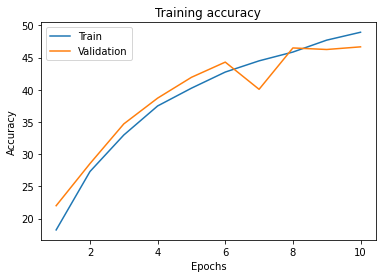

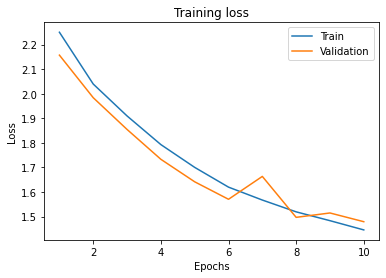

Précision en test: 48.02


In [3]:
model = CifarNet()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)
history_sgd = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_sgd.display_accuracy()
history_sgd.display_loss()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

## Exercice

Comparez trois différentes stratégies d'optimisation:
1. [SGD](http://pytorch.org/docs/master/optim.html#torch.optim.SGD)
2. SGD + Momentum accéléré de Nesterov
3. [Adam](http://pytorch.org/docs/master/optim.html#torch.optim.Adam) 

Complétez cette cellule pour entraîner avec SGD + Momentum accéléré de Nesterov. Utilisez un momentum de 0.9.

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.71s loss: 1.903386 acc: 31.030000 val_loss: 1.553157 val_acc: 44.260000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.77s loss: 1.427307 acc: 49.300000 val_loss: 1.325238 val_acc: 52.630000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.71s loss: 1.235912 acc: 56.595000 val_loss: 1.180525 val_acc: 58.280000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.73s loss: 1.087848 acc: 62.157500 val_loss: 1.179725 val_acc: 58.030000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.76s loss: 0.982314 acc: 65.707500 val_loss: 1.075714 val_acc: 62.550000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.71s loss: 0.899599 acc: 68.735000 val_loss: 1.002331 val_acc: 65.060000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 0.821407 acc: 71.712500 val_loss: 0.984477 val_acc: 66.340000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

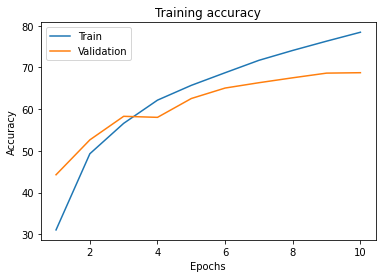

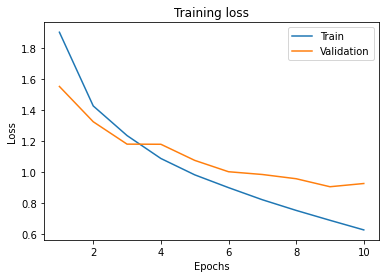

Précision en test: 69.80


In [4]:
model = CifarNet()
model.cuda()
#optimizer =
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
history_SGDMN = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_SGDMN.display_accuracy()
history_SGDMN.display_loss()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

Complétez cette cellule pour entraîner avec Adam

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.92s loss: 1.863908 acc: 33.100000 val_loss: 1.627581 val_acc: 41.310000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.81s loss: 1.505131 acc: 46.155000 val_loss: 1.443399 val_acc: 48.120000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 1.391756 acc: 50.195000 val_loss: 1.426320 val_acc: 49.460000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 1.338843 acc: 52.330000 val_loss: 1.350262 val_acc: 51.860000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.84s loss: 1.297982 acc: 53.765000 val_loss: 1.331804 val_acc: 52.820000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 1.276008 acc: 54.860000 val_loss: 1.379624 val_acc: 50.790000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 1.261820 acc: 55.042500 val_loss: 1.300386 val_acc: 53.960000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

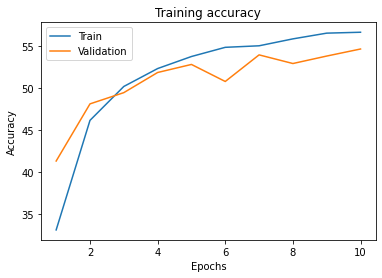

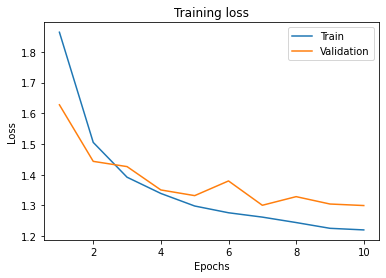

Précision en test: 54.18


In [5]:
model = CifarNet()
model.cuda()
#optimizer =
optimizer = optim.Adam(model.parameters(), lr=lr)
history_adam = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_adam.display_accuracy()
history_adam.display_loss()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

Quelle méthode semble être la meilleure dans ce cas-ci?
Remarquez-vous une différence d'overfitting?

## 2. Horaire d'entraînement

Une pratique courante utilisé en deep learning est de faire diminuer le learning rate pendant l'entraînement.

Pour ce faire PyTorch fourni plusieurs fonctions (ExponentialLR, LambdaLR, MultiStepLR, etc.)

Voici un exemple avec ExponentialLR.

In [6]:
model = CifarNet()
model.cuda()

batch_size = 128
lr = 0.01
n_epoch = 10

optimizer = optim.SGD(model.parameters(), lr=lr)

gamma = 0.99
scheduler = pt.ExponentialLR(gamma)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, callbacks=[scheduler], use_gpu=True)

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 2.281011 acc: 15.287500 val_loss: 2.230771 val_acc: 22.890000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 2.114673 acc: 24.357500 val_loss: 2.033001 val_acc: 27.180000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 1.983696 acc: 28.995000 val_loss: 1.941000 val_acc: 31.690000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.78s loss: 1.904105 acc: 32.742500 val_loss: 1.853196 val_acc: 35.140000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.73s loss: 1.809283 acc: 36.345000 val_loss: 1.799085 val_acc: 36.510000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.67s loss: 1.724826 acc: 39.102500 val_loss: 1.714749 val_acc: 39.150000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.73s loss: 1.644027 acc: 42.125000 val_loss: 1.633272 val_acc: 42.710000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

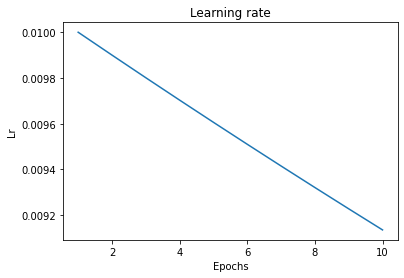

In [7]:
history.display_lr()

## Exercice

Utilisez [MultiStepLR](http://pytorch.org/docs/master/optim.html#torch.optim.lr_scheduler.MultiStepLR) pour modifier le learning rate un epoch précis. 

1. Commencez avec un learning rate trop élevé pour que le réseau puisse apprendre quelque chose.
2. Diminuez le progressivement jusqu'à ce que le réseau apprenne.
3. Trouvez le moment où la validation semble avoir atteint un plateau.
4. Diminuez le learning par 2 à ce moment et réentraîner le réseau.

In [20]:
torch.manual_seed(42)
model = CifarNet()
model.cuda()

#epoch_list = []
epoch_list = [8, 11, 12]

batch_size = 128
#lr = 10
lr = 0.5
n_epoch = 20

optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = pt.MultiStepLR(milestones=epoch_list, gamma=0.5, verbose=True)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, callbacks=[scheduler], use_gpu=True)

Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 1/20 Step: 313/313 100.00% |█████████████████████████|5.70s loss: 2.242932 acc: 15.610000 val_loss: 2.022188 val_acc: 26.750000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 2/20 Step: 313/313 100.00% |█████████████████████████|5.78s loss: 1.819558 acc: 35.022500 val_loss: 1.597064 val_acc: 42.970000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 3/20 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 1.617026 acc: 42.840000 val_loss: 1.549614 val_acc: 44.710000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 4/20 Step: 313/313 100.00% |█████████████████████████|5.82s loss: 1.385773 acc: 51.030000 val_loss: 1.432473 val_acc: 49.260000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 5/20 Step: 313/313 100.00% |█████████████████████████|5.81s loss: 1.249332 acc: 55.885000 val_loss: 1.314309 val_acc: 54.180000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 6/20 Step: 313/313

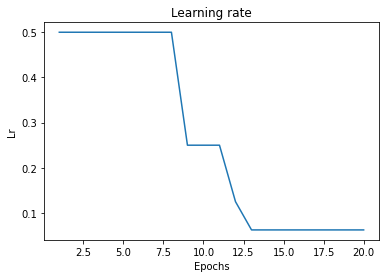

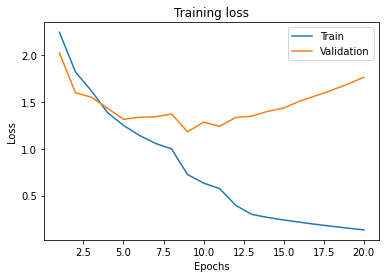

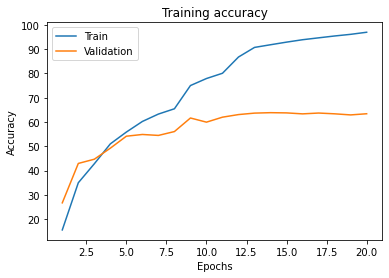

In [21]:
history.display_lr()
history.display_loss()
history.display_accuracy()

Voyez-vous une différence en diminuant le learning rate par 2 après x epochs?<br>
Pourquoi?

## 3. Batch Normalization

Voici l'architecture du réseau de neurones convolutionnels que vous avez utilisé jusqu'à présent pour faire de la classification sur Cifar10.

In [2]:
import torch.nn.functional as F

class CifarNetBatchNorm(nn.Module):
    def __init__(self):
        super(CifarNetBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 50, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(50)
        self.conv3 = nn.Conv2d(50, 150, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(150)
        self.fc1 = nn.Linear(150 * 8 * 8, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    @staticmethod
    def num_flat_features(x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Exercice

Modifier l'architecture du réseau en ajoutant de la batch norm entre les couches de convolutions et entraîner le nouveau réseau.

Comparer l'entraînement du réseau avec et sans la batch norm (Section 1 avec SGD).<br>
Que remarquez-vous?<br>

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|6.30s loss: 1.549969 acc: 46.042500 val_loss: 1.479394 val_acc: 48.770000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.90s loss: 1.137288 acc: 59.697500 val_loss: 1.111766 val_acc: 60.500000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|6.26s loss: 0.984490 acc: 65.675000 val_loss: 1.429833 val_acc: 52.180000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|6.41s loss: 0.884485 acc: 69.452500 val_loss: 1.020498 val_acc: 64.320000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|6.53s loss: 0.816916 acc: 71.960000 val_loss: 1.209531 val_acc: 60.190000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.98s loss: 0.755216 acc: 74.277500 val_loss: 1.417396 val_acc: 54.310000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|6.00s loss: 0.707929 acc: 76.135000 val_loss: 1.011741 val_acc: 65.490000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

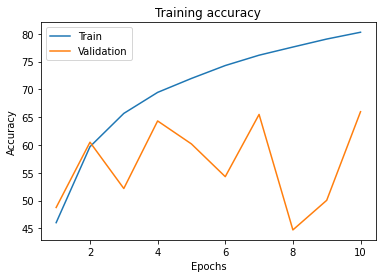

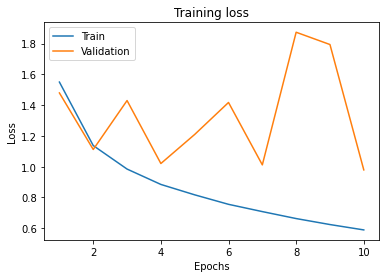

In [23]:
model = CifarNetBatchNorm()
model.cuda()

lr = 0.01
batch_size = 128
n_epoch = 10

optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history.display_accuracy()
history.display_loss()

### Effet de la batch norm sur le learning rate

Commençons par entraîner un réseau avec un haut learning rate.

In [4]:
lr = 0.5
batch_size = 1024
n_epoch = 10

In [25]:
model = CifarNet()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)

Epoch: 1/10 Step: 40/40 100.00% |█████████████████████████|5.06s loss: 2.330056 acc: 11.882500 val_loss: 2.301497 val_acc: 10.790000
Epoch: 2/10 Step: 40/40 100.00% |█████████████████████████|5.03s loss: 2.297570 acc: 11.332500 val_loss: 2.302133 val_acc: 11.720000
Epoch: 3/10 Step: 40/40 100.00% |█████████████████████████|5.02s loss: 2.275083 acc: 13.855000 val_loss: 2.303086 val_acc: 10.120000
Epoch: 4/10 Step: 40/40 100.00% |█████████████████████████|5.09s loss: 2.287980 acc: 12.970000 val_loss: 2.305801 val_acc: 10.200000
Epoch: 5/10 Step: 40/40 100.00% |█████████████████████████|5.02s loss: 2.287083 acc: 12.405000 val_loss: 2.302037 val_acc: 10.180000
Epoch: 6/10 Step: 40/40 100.00% |█████████████████████████|5.09s loss: 2.301304 acc: 10.752500 val_loss: 2.303543 val_acc: 10.050000
Epoch: 7/10 Step: 40/40 100.00% |█████████████████████████|5.03s loss: 2.278685 acc: 14.180000 val_loss: 2.229391 val_acc: 18.740000
Epoch: 8/10 Step: 40/40 100.00% |█████████████████████████|5.10s loss

Essayons maintenant d'entraîner le réseau utilisant la batchnorm avec les mêmes hyperparamètres.

In [5]:
model = CifarNetBatchNorm()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)

Epoch: 1/10 Step: 40/40 100.00% |█████████████████████████|5.23s loss: 4.836665 acc: 14.092500 val_loss: 2.229255 val_acc: 20.130000
Epoch: 2/10 Step: 40/40 100.00% |█████████████████████████|5.15s loss: 2.154441 acc: 22.295000 val_loss: 2.123561 val_acc: 23.420000
Epoch: 3/10 Step: 40/40 100.00% |█████████████████████████|5.21s loss: 2.020569 acc: 27.922500 val_loss: 2.074429 val_acc: 27.110000
Epoch: 4/10 Step: 40/40 100.00% |█████████████████████████|5.18s loss: 1.841418 acc: 34.920000 val_loss: 1.919546 val_acc: 31.250000
Epoch: 5/10 Step: 40/40 100.00% |█████████████████████████|5.18s loss: 1.680858 acc: 39.415000 val_loss: 1.986565 val_acc: 32.760000
Epoch: 6/10 Step: 40/40 100.00% |█████████████████████████|5.18s loss: 1.584677 acc: 43.065000 val_loss: 4.480415 val_acc: 12.740000
Epoch: 7/10 Step: 40/40 100.00% |█████████████████████████|5.24s loss: 1.526311 acc: 44.977500 val_loss: 1.835442 val_acc: 36.700000
Epoch: 8/10 Step: 40/40 100.00% |█████████████████████████|5.18s loss

Que pouvez-vous conclure sur l'effet de la batch norm sur le learning rate?

## Analyse

Après l'entraînement, il est important d'analyser les résultats obtenus.
Commençons par tester le réseau en utilisant la fonction `validate_ranking`.
Cette fonction sépare les résultats bien classés des erreurs et retourne pour chaque image, un score (qu'on peut voir comme une probabilité), la vraie classe et la classe prédite.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import poutyne as pt

from deeplib.history import History
from deeplib.datasets import train_valid_loaders, load_cifar10

from torchvision.transforms import ToTensor

from deeplib.net import CifarNet

from deeplib.training import train, validate_ranking, test
from deeplib.visualization import show_worst, show_random, show_best

cifar_train, cifar_test = load_cifar10()

lr = 0.5
batch_size = 1024
n_epoch = 10

import torch.nn.functional as F

class CifarNetBatchNorm(nn.Module):
    def __init__(self):
        super(CifarNetBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 50, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(50)
        self.conv3 = nn.Conv2d(50, 150, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(150)
        self.fc1 = nn.Linear(150 * 8 * 8, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    @staticmethod
    def num_flat_features(x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = CifarNetBatchNorm()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)

good, errors = validate_ranking(model, cifar_test, batch_size, use_gpu=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1/10 Step: 40/40 100.00% |█████████████████████████|5.23s loss: 5.378432 acc: 14.002500 val_loss: 2.252673 val_acc: 18.750000
Epoch: 2/10 Step: 40/40 100.00% |█████████████████████████|5.18s loss: 2.077753 acc: 26.517500 val_loss: 2.229313 val_acc: 22.270000
Epoch: 3/10 Step: 40/40 100.00% |█████████████████████████|5.17s loss: 1.773020 acc: 36.010000 val_loss: 1.940252 val_acc: 30.760000
Epoch: 4/10 Step: 40/40 100.00% |█████████████████████████|5.17s loss: 1.633110 acc: 40.670000 val_loss: 1.856494 val_acc: 31.680000
Epoch: 5/10 Step: 40/40 100.00% |█████████████████████████|5.21s loss: 1.538855 acc: 43.767500 val_loss: 2.367473 val_acc: 31.990000
Epoch: 6/10 Step: 40/40 100.00% |█████████████████████████|5.14s loss: 1.503240 acc: 45.515000 val_loss: 2.173540 val_acc: 28.810000
Epoch: 7/10 Step: 40/40 100.00% |█████████████████████████|5.22s loss: 1.442146 acc: 47.512500 val_loss: 1.966518 val_acc: 36.

Maintenant, regardons quelques exemples d'images bien classées.

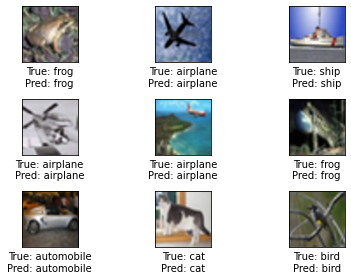

In [2]:
show_random(good)

Et quelques exemples mal classées.

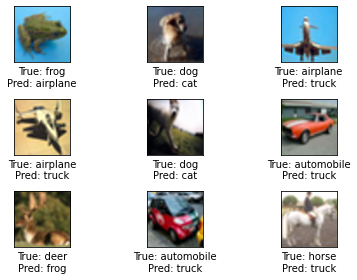

In [3]:
show_random(errors)

Il est aussi possible de regarder les exemples où le réseau est le plus confiant.

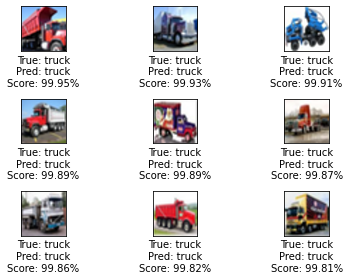

In [4]:
show_best(good)

Ou l'inverse, ceux qui ont obtenus les moins bons scores.

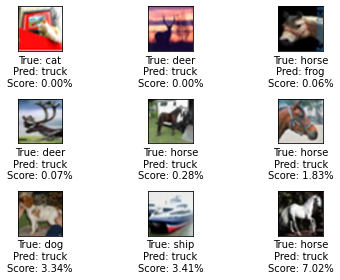

In [5]:
show_worst(errors)

Finalement, il peut être intéressant de regarder les exemples les plus difficiles.
Soit ceux qui ont été bien classé, mais qui ont eu un mauvais score.

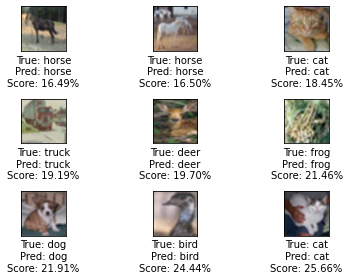

In [6]:
show_worst(good)

Ou ceux qui été mal classé, mais qui ont quand même réussi à obtenir un bon score.

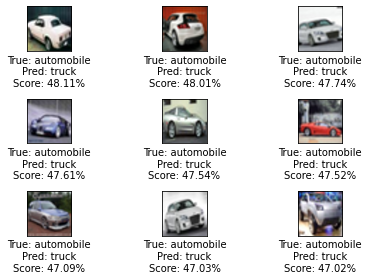

In [7]:
show_best(errors)

En observant les résultats obtenus, que pouvez-vous dire sur les performances du réseau? <br>
Quelle classe semble être facile? Pourquoi? <br>
Quelle classe semble être difficile? Pourquoi? <br>